In [1]:
import os
import re
import numpy as np
import pandas as pd
import pickle as pkl
from metallum import Band, Album, Song

import nltk
from nltk.corpus import stopwords
languages = ['english', 'german', 'french', 'finnish', 'swedish', 'norwegian', 'danish', 'russian']
stop_words = set()
for language in languages:
    stop_words.update(set(stopwords.words(language)))
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [2]:
LYRICS_DIR = 'lyrics/'
BANDS_DIR = 'bands/'

In [3]:
band_filenames = [f for f in os.listdir(BANDS_DIR) if '.pkl' in f]
bands = [pkl.load(open(os.path.join(BANDS_DIR, f), 'rb')) for f in band_filenames]
band_genres = {b.name.lower(): b.genres for b in bands}

In [4]:
lyrics_filenames = [f for f in os.listdir(LYRICS_DIR) if '.pkl' in f]
lyrics = {filename.replace('.pkl', ''): pkl.load(open(os.path.join(LYRICS_DIR, filename), 'rb')) for filename in lyrics_filenames}
corpus = []
band_names = []
song_names = []
vocabulary = set()
genres = []
for band, band_lyrics in lyrics.items():
    if band in band_genres.keys():
        for album, album_lyrics in band_lyrics.items():
            for song, song_lyrics in album_lyrics.items():
                words = []
                for line in song_lyrics:
                    for w in line.split():
                        s = re.search("(\w+)|(\w+([-'])(\w+)?[']?(\w+))", w.lower())
                        if s:
                            w = s.group()
                            if True: #w in english_vocab and w not in stop_words:
                                words.append(w)
                song_name = []
                for w in song.split():
                    s = re.search("(\w+)|(\w+([-'])(\w+)?[']?(\w+))", re.sub('\d+\.', '', w).lower())
                    if s:
                        song_name.append(s.group())
                song_name = ' '.join(song_name)
                document = ' '.join(words)
                if len(document) > 0:
                    corpus.append(document)
                    band_names.append(band)
                    song_names.append(song_name)
                    vocabulary.update(set(words))
                    genres.append(band_genres[band])
print("vocabulary size: {}".format(len(vocabulary)))

vocabulary size: 171518


# Features dataframe

In [5]:
df_rows = [
    {'band': band_names[i], 'song': song_names[i], 'lyrics': corpus[i], 'genres': genres[i]} for i in range(len(corpus))
]
df = pd.DataFrame(df_rows, columns=['band', 'song', 'lyrics', 'genres'])
df = df.drop_duplicates(subset=['band', 'song'])
print(df.shape)
df.head()

(42460, 4)


,band,song,lyrics,genres
0,aarni,myrrys,ääni tuulen varjot puiden yksinäni uneksin hal...,"[avant-garde, doom]"
1,aarni,the black keyes of r,five hundred years has gone since i summoned t...,"[avant-garde, doom]"
2,aarni,metsänpeitto sample 1 2,metsäpolulta metsän polulle metsänpeitossa fro...,"[avant-garde, doom]"
3,aarni,persona mortuae cutis,yog est clavis portaque cum primis digitis cut...,"[avant-garde, doom]"
4,aarni,ubbo,for ubbo is the source and the end before the ...,"[avant-garde, doom]"


In [6]:
song_lengths = df['lyrics'].apply(lambda x: len(x.split()))
print(round(song_lengths.mean()), round(song_lengths.std()), song_lengths.min(), song_lengths.max())

160 85 1 1598


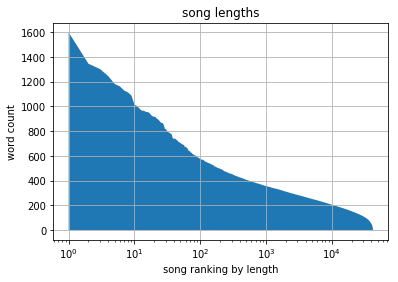

In [7]:
plt.fill_between(range(1, df.shape[0] + 1), 0, song_lengths.sort_values()[::-1].reset_index(drop=True))
plt.title("song lengths")
plt.xlabel('song ranking by length')
plt.ylabel('word count')
plt.xscale('log')
plt.grid(axis='both')
plt.show()

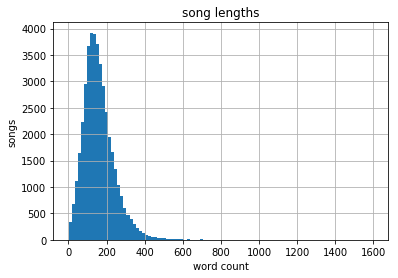

In [8]:
song_lengths.hist(bins=100)
plt.title("song lengths")
plt.xlabel('word count')
plt.ylabel('songs')
plt.show()

# Labels dataframe

In [9]:
unique_genres = sorted(set([x for lst in df['genres'].tolist() for x in lst]))
df_genres = pd.DataFrame(index=df.index, columns=unique_genres)
for genre in unique_genres:
    df_genres[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)
top_genres = df_genres.columns[df_genres.mean(axis=0) > 0.1]
df_genres = df_genres[top_genres]
df_genres['other'] = (df_genres.sum(axis=1) == 0).astype(int)
df_genres.head()

,black,death,heavy,melodic,power,progressive,thrash,other
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1


In [10]:
df_genres.mean(axis=0)

black          0.228073
death          0.326872
heavy          0.161634
melodic        0.106877
power          0.164225
progressive    0.110551
thrash         0.192628
other          0.136034
dtype: float64

# Tokenization & oversampling

In [11]:
corpus_train, corpus_test, y_train, y_test = train_test_split(df['lyrics'].values, df_genres['death'].values, test_size=0.2)

In [12]:
maxlen = song_lengths.max()

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(corpus_train)

vocab_size = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(corpus_train)
X_test = tokenizer.texts_to_sequences(corpus_test)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33968, 1598) (8492, 1598) (33968,) (8492,)


# Test with Keras model

In [13]:
def cross_validation(clf, n_splits=5, shuffle=True, random_state=None, oversampler=None, verbose=True, clf_args=(), clf_kwargs={}):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    scores = np.zeros(n_splits)
    losses = np.zeros(n_splits)
    models = []
    for i, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
        if verbose:
            print("FOLD {}".format(i + 1))
        X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
        X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx]
        if oversampler:
            X_fold_train, y_fold_train = oversampler.fit_resample(X_fold_train, y_fold_train)
        model = clf(*clf_args, **clf_kwargs)
        if clf.__name__ == 'KerasClassifier':
            model.fit(X_fold_train, y_fold_train, validation_data=(X_fold_valid, y_fold_valid))
        else:
            model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_valid)
        y_fold_prob = model.predict_proba(X_fold_valid)
        scores[i] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
        losses[i] = log_loss(y_fold_valid, y_fold_prob)
        if verbose:
            print("balanced accuracy score = {:.4f} ... log loss = {:.2f}".format(scores[i], losses[i]))
            print("confusion matrix:")
            print(confusion_matrix(y_fold_valid, y_fold_pred))
        models.append(model)
    if verbose:
        print("average balanced accuracy score = {:.4} +/- {:.4f}".format(scores.mean(), scores.std() * 2))
        print("average log loss = {:.2} +/- {:.2f}".format(losses.mean(), losses.std() * 2))
    return models, scores, losses

def predict_report(clf, X_train, y_train, X_test, y_test, oversampler=None, verbose=True, clf_args=(), clf_kwargs={}):
    model = clf(*clf_args, **clf_kwargs)
    if oversampler:
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    print("balanced accuracy score = {:.4f}".format(balanced_accuracy_score(y_test, y_pred)))
    print("log loss = {:.2f}".format(log_loss(y_test, y_prob)))
    print("confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    return model, y_pred, y_prob

def plot_history(models, metrics, epochs):
    x = range(1, epochs + 1)
    fig, axes = plt.subplots(metrics.shape[0], metrics.shape[1], figsize=(16, 5 * metrics.shape[0]))
    for i, metric in enumerate(metrics.flatten()):
        ax = axes.flatten()[i]
        histories = np.zeros((epochs, len(models)))
        for j, model in enumerate(models):
            history = model.model.history.history[metric]
            history += [history[-1]] * (epochs - len(history))
            histories[:, j] = history
        mean = histories.mean(axis=1)
        std = histories.std(axis=1)
        ax.plot(x, mean, c='k', lw=2)
        ax.fill_between(x, mean - std, mean + std, color='k', alpha=0.1)
        for j in range(histories.shape[1]):
            ax.plot(x, histories[:, j], '--')
        ax.set_ylim(0, 1)
        ax.set_xticks(x)
        ax.set_xlabel('epoch', size=14)
        ax.set_ylabel(metric, size=14)
        ax.grid()
    plt.show()

In [23]:
def create_model(input_dim=None, embedding_dim=None, input_length=maxlen):
    model = Sequential()
    model.add(layers.Embedding(input_dim=input_dim,
                               output_dim=embedding_dim,
                               input_length=input_length))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [28]:
nn_params = dict(
    input_dim=vocab_size,
    embedding_dim=50,
    epochs=3,
    batch_size=256,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.01, patience=0)]
)

models, scores, losses = cross_validation(
    KerasClassifier,
    random_state=0,
    oversampler=RandomOverSampler(random_state=0),
    clf_args=(create_model,),
    clf_kwargs=nn_params
)

FOLD 1
Train on 36572 samples, validate on 6794 samples
Epoch 1/3
36572/36572 [==============================] - 159s 4ms/step - loss: 0.6086 - acc: 0.6612 - val_loss: 0.5758 - val_acc: 0.6963
Epoch 2/3
6794/6794 [==============================] - 8s 1ms/step
balanced accuracy score = 0.6864 ... log loss = 0.58
confusion matrix:
[[3416 1156]
 [ 832 1390]]
FOLD 2
Train on 36572 samples, validate on 6794 samples
Epoch 1/3
36572/36572 [==============================] - 158s 4ms/step - loss: 0.6115 - acc: 0.6626 - val_loss: 0.5903 - val_acc: 0.6746
Epoch 2/3
36572/36572 [==============================] - 156s 4ms/step - loss: 0.4559 - acc: 0.7938 - val_loss: 0.5461 - val_acc: 0.7256
Epoch 3/3
6794/6794 [==============================] - 8s 1ms/step
balanced accuracy score = 0.6772 ... log loss = 0.61
confusion matrix:
[[3863  709]
 [1090 1132]]
FOLD 3
Train on 36572 samples, validate on 6794 samples
Epoch 1/3
36572/36572 [==============================] - 158s 4ms/step - loss: 0.6122 - acc

In [29]:
model, y_pred, y_prob = predict_report(
    KerasClassifier,
    X_train,
    y_train,
    X_test,
    y_test,
    oversampler=RandomOverSampler(random_state=0),
    clf_args=(create_model,),
    clf_kwargs=nn_params
)

Epoch 1/3
45716/45716 [==============================] - 187s 4ms/step - loss: 0.6029 - acc: 0.6637
Epoch 2/3


/home/philippe/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


45716/45716 [==============================] - 186s 4ms/step - loss: 0.4554 - acc: 0.7900
Epoch 3/3
8492/8492 [==============================] - 10s 1ms/step
balanced accuracy score = 0.6929
log loss = 0.61
confusion matrix:
[[4510 1213]
 [1114 1655]]


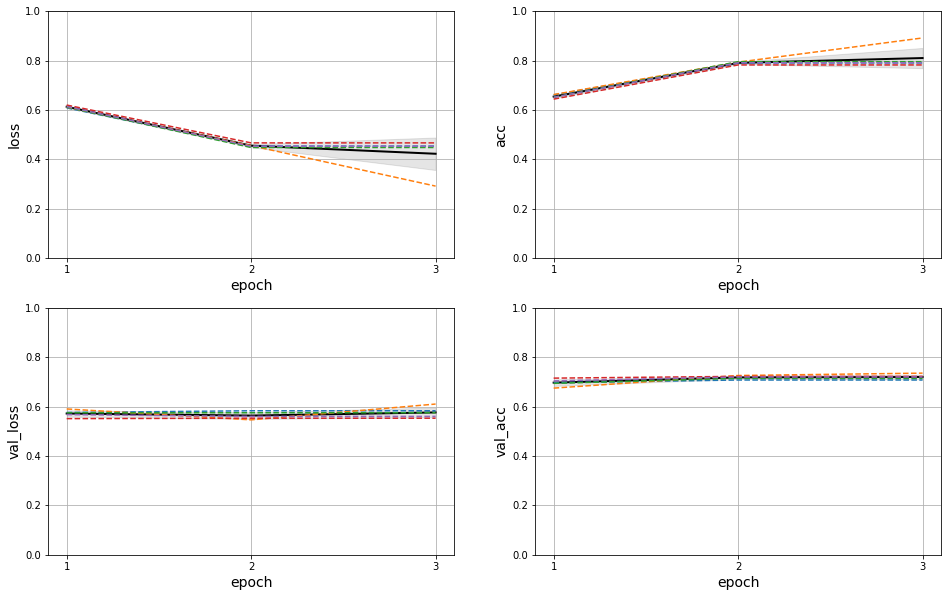

In [30]:
plot_history(
    models,
    np.array([
        ['loss', 'acc'],
        ['val_loss', 'val_acc']
    ]),
    nn_params['epochs']
)

In [250]:
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
scores = np.zeros(n_splits)
losses = np.zeros(n_splits)
models = []
for i, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    print("FOLD {}".format(i + 1))
    X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
    X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx]
    X_fold_train, y_fold_train = RandomOverSampler(random_state=0).fit_resample(X_fold_train, y_fold_train)
    model = KerasClassifier(create_model, **model_params)
    model.fit(X_fold_train, y_fold_train, validation_data=(X_fold_valid, y_fold_valid))
    y_fold_pred = model.predict(X_fold_valid)
    y_fold_prob = model.predict_proba(X_fold_valid)
    scores[i] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    losses[i] = log_loss(y_fold_valid, y_fold_prob)
    print("balanced accuracy score = {:.4f} ... log loss = {:.2f}".format(scores[i], losses[i]))
    print("confusion matrix:")
    print(confusion_matrix(y_fold_valid, y_fold_pred))
    models.append(model)
print("average balanced accuracy score = {:.4} +/- {:.4f}".format(scores.mean(), scores.std() * 2))
print("average log loss = {:.2} +/- {:.2f}".format(losses.mean(), losses.std() * 2))

FOLD 1
balanced accuracy score = 0.6982 ... log loss = 0.57
confusion matrix:
[[3332 1232]
 [ 744 1486]]
FOLD 2
balanced accuracy score = 0.6804 ... log loss = 0.62
confusion matrix:
[[3517 1047]
 [ 914 1316]]
FOLD 3
balanced accuracy score = 0.6542 ... log loss = 0.66
confusion matrix:
[[3853  711]
 [1195 1035]]
FOLD 4
balanced accuracy score = 0.6785 ... log loss = 0.62
confusion matrix:
[[3613  951]
 [ 969 1260]]
FOLD 5
balanced accuracy score = 0.6730 ... log loss = 0.62
confusion matrix:
[[3643  921]
 [1008 1221]]
average balanced accuracy score = 0.6768 +/- 0.0283
average log loss = 0.62 +/- 0.05


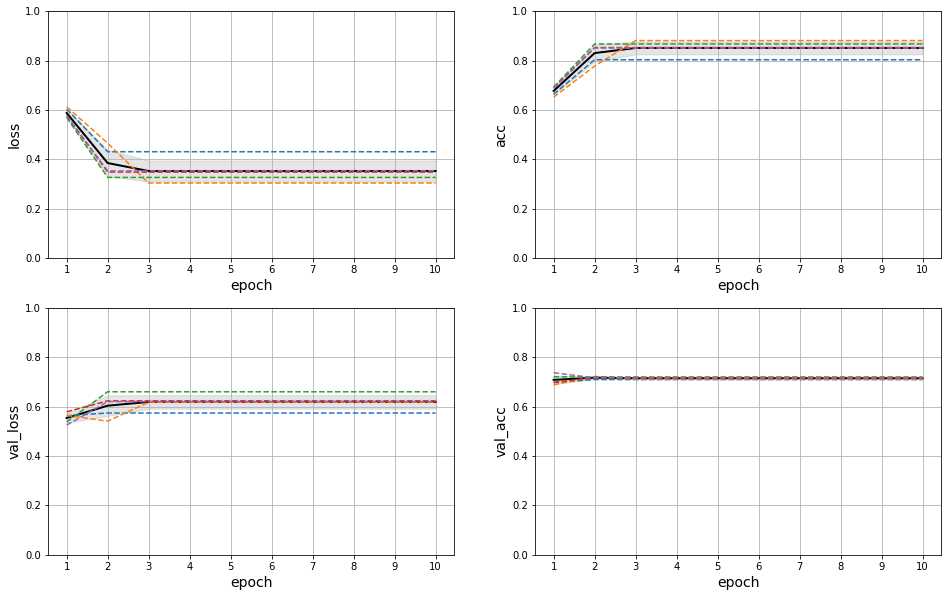

In [251]:
epochs = range(1, model_params['epochs'] + 1)
metrics = np.array([
    ['loss', 'acc'],
    ['val_loss', 'val_acc']
])
# metrics = np.array(['loss', 'acc'])
fig, axes = plt.subplots(metrics.shape[0], metrics.shape[1], figsize=(16, 5 * metrics.shape[0]))
for i, metric in enumerate(metrics.flatten()):
    ax = axes.flatten()[i]
    histories = np.zeros((len(epochs), len(models)))
    for j, model in enumerate(models):
        history = model.model.history.history[metric]
        history += [history[-1]] * (len(epochs) - len(history))
        histories[:, j] = history
    mean = histories.mean(axis=1)
    std = histories.std(axis=1)
    ax.plot(epochs, mean, c='k', lw=2)
    ax.fill_between(epochs, mean - std, mean + std, color='k', alpha=0.1)
    for j in range(histories.shape[1]):
        ax.plot(epochs, histories[:, j], '--')
    ax.set_ylim(0, 1)
    ax.set_xticks(epochs)
    ax.set_xlabel('epoch', size=14)
    ax.set_ylabel(metric, size=14)
    ax.grid()
plt.show()

In [252]:
model = KerasClassifier(create_model, **model_params)
X_train_r, y_train_r = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)
model.fit(X_train_r, y_train_r, validation_data=None)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
print("balanced accuracy score = {:.4f}".format(balanced_accuracy_score(y_test, y_pred)))
print("log loss = {:.2f}".format(log_loss(y_test, y_prob)))
print("confusion matrix:")
print(confusion_matrix(y_test, y_pred))

/home/philippe/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


balanced accuracy score = 0.6549
log loss = 1.30
confusion matrix:
[[4631 1130]
 [1349 1382]]


In [60]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='balanced_accuracy')
print("CV score: {:.1f}% +/- {:.1f}%".format(scores.mean() * 100, scores.std() * 200))

Epoch 1/10
 - 7s - loss: 0.6917 - acc: 0.5397
Epoch 2/10
 - 6s - loss: 0.6897 - acc: 0.5435
Epoch 3/10


KeyboardInterrupt: 

### With global max pooling instead of flattening

In [280]:
embedding_dim = 50

def create_model(input_dim=None, output_dim=None, input_length=maxlen):
    model = Sequential()
    model.add(layers.Embedding(input_dim=input_dim,
                               output_dim=output_dim,
                               input_length=input_length))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(create_model, input_dim=vocab_size, output_dim=embedding_dim, epochs=5, batch_size=10, verbose=False)

In [281]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='balanced_accuracy')
print("CV score: {:.1f}% +/- {:.1f}%".format(scores.mean() * 100, scores.std() * 200))

CV score: 87.3% +/- 9.4%


In [297]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))

0.5


### Convolutional neural network

In [284]:
embedding_dim = 50

def create_model(input_dim=None, output_dim=None, input_length=maxlen):
    model = Sequential()
    model.add(layers.Embedding(input_dim=input_dim,
                               output_dim=output_dim,
                               input_length=input_length))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(create_model, input_dim=vocab_size, output_dim=embedding_dim, epochs=5, batch_size=10, verbose=False)

In [298]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='balanced_accuracy')
print("CV score: {:.1f}% +/- {:.1f}%".format(scores.mean() * 100, scores.std() * 200))

CV score: 50.0% +/- 0.0%


In [297]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))

0.5
